# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.

---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


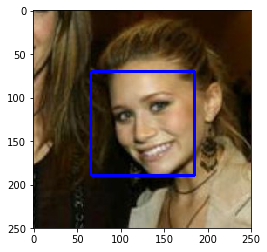

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
faces_in_human_files = [int(face_detector(img)) for img in human_files_short]
faces_in_dog_files = [int(face_detector(img)) for img in dog_files_short]

nb_faces_in_human_files = np.sum(faces_in_human_files)
print('Detected {0} faces in human files - {1}% success'.format(nb_faces_in_human_files,100*nb_faces_in_human_files/len(human_files_short)))
nb_faces_in_dog_files = np.sum(faces_in_dog_files)
print('Detected {0} faces in dog files - {1}% error'.format(nb_faces_in_dog_files,100*nb_faces_in_dog_files/len(dog_files_short)))

Detected 98 faces in human files - 98.0% success
Detected 11 faces in dog files - 11.0% error


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

__Solution__: In addition to detecting faces, we can also use an eye detector. If we can detect a least one face and one human eye (with or without glasses), then we can be more confident that the photo contain a humain face and not a dog. If we cannot detect any eye, it probably mean that the photo is not framed well enough and we can reject it, asking the user to take another one.

In [6]:
import requests

# download the eyes detector
response = requests.get('https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml')
xml = response.content
# save to disk
file = open('haarcascades/haarcascade_eye.xml','wb')
file.write(xml)
file.close()
# download the "eyes with glasses" detector
response = requests.get('https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye_tree_eyeglasses.xml')
xml = response.content
# save to disk
file = open('haarcascades/haarcascade_eye_tree_eyeglasses.xml','wb')
file.write(xml)
file.close()

Number of faces detected: 1


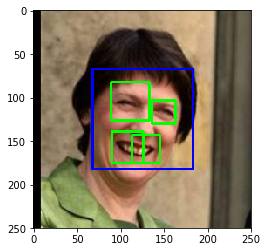

In [7]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')
eye_glasses_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye_tree_eyeglasses.xml')

# load color (BGR) image
img = cv2.imread(human_files[12])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    # try to detect eyes
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    # if cannot detect any eye, try to detect eyes with glasses
    if len(eyes)==0:
        eyes_glasses = eye_glasses_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes_glasses:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [8]:
def face_detector2(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    
    for (x,y,w,h) in faces:
        # try to detect eyes
        roi_gray = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        # if no eyes, detected, look for glasses
        if len(eyes)==0:
            eyes_glasses = eye_glasses_cascade.detectMultiScale(roi_gray)
            
    
    return (len(faces) > 0) and (len(eyes)>=1 or len(eyes_glasses)>=1)

In [9]:
## (Optional) Report the performance of another  
## face detection algorithm on the LFW dataset

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
faces_in_human_files = [int(face_detector2(img)) for img in human_files_short]
faces_in_dog_files = [int(face_detector2(img)) for img in dog_files_short]

nb_faces_in_human_files = np.sum(faces_in_human_files)
print('Detected {0} faces in human files - {1}% success'.format(nb_faces_in_human_files,100*nb_faces_in_human_files/len(human_files_short)))
nb_faces_in_dog_files = np.sum(faces_in_dog_files)
print('Detected {0} faces in dog files - {1}% error'.format(nb_faces_in_dog_files,100*nb_faces_in_dog_files/len(dog_files_short)))

Detected 84 faces in human files - 84.0% success
Detected 1 faces in dog files - 1.0% error


As reported above, our detection algorithm is more restrictive and reject some of the human photos, but is able to reject 99% of the dog photos (highest precision). This will work better for our application as we can ask the user for a better image if we cannot detect a human, but wrongly detecting a human face in a dog image would be an issue.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [10]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 2s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [12]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dogs_in_human_files = [int(dog_detector(img)) for img in human_files_short]
dogs_in_dog_files = [int(dog_detector(img)) for img in dog_files_short]

nb_dogs_in_human_files = np.sum(dogs_in_human_files)
print('Detected {0} dogs in human files - {1}% error'.format(nb_dogs_in_human_files,100*nb_dogs_in_human_files/len(human_files_short)))
nb_dogs_in_dog_files = np.sum(dogs_in_dog_files)
print('Detected {0} faces in dog files - {1}% success'.format(nb_dogs_in_dog_files,100*nb_dogs_in_dog_files/len(dog_files_short)))

Detected 1 dogs in human files - 1.0% error
Detected 100 faces in dog files - 100.0% success


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [15]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 102.63it/s]


### (IMPLEMENTATION) Model Architecture
          
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

As a first step I was inspired by Alexnet, that is made of 5 convolution layers followed by 3 fully connected layers. This network performed well on the ImageNet classification problem in 2012. The dog classification problem requires to detect small variations in images and extract "non obvious" features. 

Therefore, the bottom part of my first deep learning architecture is made of 5 convolutional layers, each followed by a pooling layer. These five steps allow to reduce the spatial dimensionality of the problem and extract significant features. I used RELU activation function for the convolutional layers as it converges significantly faster than an equivalent network with tanh activation. In addition, the dataset is fairly small with only 6680 images in 133 categories, so there is a risk to overfit the training data.  In order to help preventing this problem, I added dropout layers after each convolution layers.

These convolutational layers were followed by a Global Average Pooling layer to flatten the features in a vector, than is then fed into a softmax classification layer. According to [this paper published in 2014](https://arxiv.org/pdf/1312.4400.pdf), Global Average Pooling is easier to interpret and less prone to overfitting than traditionnal fully connected layers used in the original AlexNet. 

This first architecture, trained over 50 epochs, reached a cross validation accuracy of 31.1%. 

Even if this first implementation performed well above the 1% target, I decided to refine the architecture to increase the accuracy. Instead of using a 11x11 convolution for the first layer, I decided to stack 3 convolutions with 3x3 kernels. Using smaller filters instead of large receptive fields allow us to express more powerful features of the input, with fewer parameters. As a practical disavantage it will need more memory to hold all the intermediate convolutional layer results when performing backpropagation. This second architecture reached a cross validation accuracy of 36.7%, and a test accuracy of 35.8%.


In [17]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [40]:
model = Sequential()

# First, stack 3 convolutional layers
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(224,224, 3)))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(224,224, 3)))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', 
                        input_shape=(224,224, 3)))

# Then max pooling layer
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
# Fourth convolution
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Fifth convolution
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# Sixth convolution
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# GAP
model.add(GlobalAveragePooling2D())

# finish by a softmax layer
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 56, 56, 128)       0         
__________

### Compile the Model

In [41]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [42]:
from keras.callbacks import ModelCheckpoint  

### number of epochs to use to train the model.
epochs = 50

# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 224s 34ms/step - loss: 4.8855 - acc: 0.0091 - val_loss: 4.8748 - val_acc: 0.0108
Epoch 2/50
6680/6680 [==============================] - 220s 33ms/step - loss: 4.8610 - acc: 0.0135 - val_loss: 4.8370 - val_acc: 0.0216
Epoch 3/50
6680/6680 [==============================] - 220s 33ms/step - loss: 4.7924 - acc: 0.0211 - val_loss: 4.7406 - val_acc: 0.0228
Epoch 4/50
6680/6680 [==============================] - 220s 33ms/step - loss: 4.7103 - acc: 0.0290 - val_loss: 4.6262 - val_acc: 0.0371
Epoch 5/50
6680/6680 [==============================] - 220s 33ms/step - loss: 4.6315 - acc: 0.0346 - val_loss: 4.6393 - val_acc: 0.0275
Epoch 6/50
6680/6680 [==============================] - 220s 33ms/step - loss: 4.5511 - acc: 0.0403 - val_loss: 4.5068 - val_acc: 0.0551
Epoch 7/50
6680/6680 [==============================] - 221s 33ms/step - loss: 4.4627 - acc: 0.0463 - val_loss: 4.4121 - val_acc: 0

### Load the Model with the Best Validation Loss

In [43]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model


In [44]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 35.7656%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds (Transfer Learning from VGG16)

To reduce training time without sacrificing accuracy, we train a CNN using transfer learning.  

### Obtain Bottleneck Features for VGG16

In [45]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [46]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_12  (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [47]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [48]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=40, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 2s 323us/step - loss: 12.4756 - acc: 0.1180 - val_loss: 11.0816 - val_acc: 0.2036
Epoch 2/40
6680/6680 [==============================] - 2s 244us/step - loss: 10.4051 - acc: 0.2650 - val_loss: 10.2626 - val_acc: 0.2778
Epoch 3/40
6680/6680 [==============================] - 2s 243us/step - loss: 9.8866 - acc: 0.3290 - val_loss: 10.2401 - val_acc: 0.2934
Epoch 4/40
6680/6680 [==============================] - 2s 243us/step - loss: 9.6749 - acc: 0.3606 - val_loss: 10.1378 - val_acc: 0.2922
Epoch 5/40
6680/6680 [==============================] - 2s 242us/step - loss: 9.5325 - acc: 0.3753 - val_loss: 10.0020 - val_acc: 0.3042
Epoch 6/40
6680/6680 [==============================] - 2s 241us/step - loss: 9.3200 - acc: 0.3894 - val_loss: 9.7901 - val_acc: 0.3257
Epoch 7/40
6680/6680 [==============================] - 2s 240us/step - loss: 9.0966 - acc: 0.4106 - val_loss: 9.7565 - val_acc: 0

Epoch 27/40
6680/6680 [==============================] - 2s 242us/step - loss: 6.9528 - acc: 0.5615 - val_loss: 7.9254 - val_acc: 0.4455
Epoch 28/40
6680/6680 [==============================] - 2s 240us/step - loss: 6.9021 - acc: 0.5630 - val_loss: 7.8670 - val_acc: 0.4527
Epoch 29/40
6680/6680 [==============================] - 2s 241us/step - loss: 6.8705 - acc: 0.5677 - val_loss: 7.8455 - val_acc: 0.4503
Epoch 30/40
6680/6680 [==============================] - 2s 240us/step - loss: 6.8615 - acc: 0.5704 - val_loss: 7.8393 - val_acc: 0.4563
Epoch 31/40
6680/6680 [==============================] - 2s 240us/step - loss: 6.8482 - acc: 0.5722 - val_loss: 7.8430 - val_acc: 0.4635
Epoch 32/40
6680/6680 [==============================] - 2s 241us/step - loss: 6.8421 - acc: 0.5722 - val_loss: 7.8356 - val_acc: 0.4599
Epoch 33/40
6680/6680 [==============================] - 2s 241us/step - loss: 6.7981 - acc: 0.5714 - val_loss: 7.8098 - val_acc: 0.4539
Epoch 34/40
6680/6680 [==================

### Load the Model with the Best Validation Loss

In [49]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [50]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.4545%


### Predict Dog Breed with the Model

In [51]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (Transfer Learning from InceptionV3)

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we are going to use the bottleneck features from a different pre-trained model: GoogLeNet.


### (IMPLEMENTATION) Obtain Bottleneck Features for GoogLeNet (Inception)


GoogLeNet (also called Inception) is a 22 layer CNN that was the winner of ILSVRC 2014 with a top 5 error rate of 6.7%. This network uses a sequence of 9 "Inception modules" that perform max pooling and convolutions in parallel. Overall it includes over 100 layers, but uses average pooling instead of fully connected layers, which save a lot of parameters. 

<img src="https://adeshpande3.github.io/assets/GoogLeNet.png">

In [52]:
# download the bottleneck features for Inception net
response = requests.get('https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz')
npz = response.content
# save to disk
with open('bottleneck_features/DogInceptionV3Data.npz','wb') as file:
    file.write(npz)
    file.close()

In [53]:
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

  
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



The Inception neural network was trained on the ImageNet dataset. We have a small datasets of images that are similar to the ones used for the ImageNet competition. Therefore, we will use the Inception net as a fixed feature extractor and feed the output from this network to our model. We keep all the weights from the Inception network, and only add a global average pooling layer and a fully connected layer with softmax activation to classify the 133 dog breeds.

In [54]:
Inception_model = Sequential()
Inception_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
Inception_model.add(Dense(133, activation='softmax'))
Inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_13  (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [55]:
Inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [56]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', 
                               verbose=1, save_best_only=True)

Inception_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 385us/step - loss: 1.1639 - acc: 0.7069 - val_loss: 0.6530 - val_acc: 0.8144
Epoch 2/20
6680/6680 [==============================] - 2s 304us/step - loss: 0.4744 - acc: 0.8597 - val_loss: 0.6043 - val_acc: 0.8287
Epoch 3/20
6680/6680 [==============================] - 2s 300us/step - loss: 0.3649 - acc: 0.8835 - val_loss: 0.7152 - val_acc: 0.8251
Epoch 4/20
6680/6680 [==============================] - 2s 302us/step - loss: 0.2983 - acc: 0.9100 - val_loss: 0.7058 - val_acc: 0.8371
Epoch 5/20
6680/6680 [==============================] - 2s 300us/step - loss: 0.2436 - acc: 0.9256 - val_loss: 0.7058 - val_acc: 0.8479
Epoch 6/20
6680/6680 [==============================] - 2s 303us/step - loss: 0.2069 - acc: 0.9352 - val_loss: 0.7311 - val_acc: 0.8419
Epoch 7/20
6680/6680 [==============================] - 2s 301us/step - loss: 0.1759 - acc: 0.9439 - val_loss: 0.7013 - val_acc: 0.8359
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [57]:
Inception_model.load_weights('saved_models/weights.best.Inception.hdf5')

### (IMPLEMENTATION) Test the Model


In [58]:
# get index of predicted dog breed for each image in test set
Inception_predictions = [np.argmax(Inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Inception_predictions)==np.argmax(test_targets, axis=1))/len(Inception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.5024%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Now let's write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, this function will have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.


In [59]:
from extract_bottleneck_features import *

def Inception_predict_breed(img_path):
    """Returns the dog breed predicted by Inception"""
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Inception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


### (IMPLEMENTATION) Write your Algorithm

First, let's write a function that accepts a file path to an image and check if this is a human, a dog, or neither

In [60]:
def get_type(img_path):
    # first, test if this is a human
    if face_detector2(img_path):
        return "human"
    elif dog_detector(img_path):
        return "dog"
    else:
        raise ValueError('Neither a dog nor a human')

In [61]:
def show_image(img_path):
    # load image file
    img = cv2.imread(img_path)
    # convert BGR to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)

In [62]:
def app(img_path):
    try:
        # check if the image contains a dog or a human:
        img_type = get_type(img_path)
        # predict the breed
        breed = Inception_predict_breed(img_path)
        
        # display output
        print('Hello {0}!'.format(img_type))
        show_image(img_path)
        
        if img_type=='dog':
            print('You are a {}'.format(breed))
        else:
            print('You look like a...\n{0}!'.format(breed))
        
    except:
        print('This is not a human nor a dog')
        

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

We download 6 images from Wikipedia: two dogs, two politicians (Barack Obama, Justin Trudeau), and two other animals (Cat, Orangutan)

In [63]:
# define list of images:
urls = [
    "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Emily_Maltese.jpg/1280px-Emily_Maltese.jpg", # bichon (Wikipedia)
    "https://upload.wikimedia.org/wikipedia/commons/thumb/5/51/DSHwiki.jpg/400px-DSHwiki.jpg", # german shepherd (Wikipedia)
    "https://upload.wikimedia.org/wikipedia/commons/b/b9/CyprusShorthair.jpg", # cat (Wikipedia)
    "https://upload.wikimedia.org/wikipedia/commons/8/8a/Orangutan_01.jpg", # Orangutan
    "https://upload.wikimedia.org/wikipedia/commons/d/df/Trudeau_headshot_2008.jpg", # Justin Trudeau (Wikipedia)
    "https://upload.wikimedia.org/wikipedia/commons/e/e9/Official_portrait_of_Barack_Obama.jpg" # Barack Obama
] 

In [64]:
def download_img(url, filename):
    # download the eyes detector
    response = requests.get(url)
    img = response.content
    # save to disk
    with open('test_img/'+filename,'wb') as file:
        file.write(img)
        file.close()
        
for i,url in enumerate(urls):
    print('Downloading image ',i)
    download_img(url,str(i)+'.jpg')

87916544/87910968 [==============================] - 2s 0us/step
Hello dog!
You are a Maltese


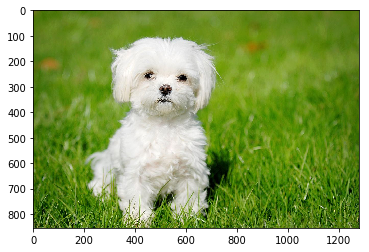

In [65]:
app("test_img/0.jpg")

Hello dog!
You are a German_shepherd_dog


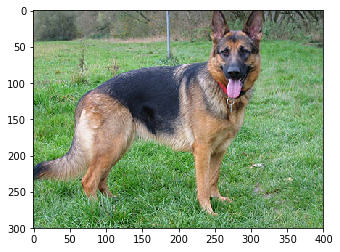

In [66]:
app("test_img/1.jpg")

In [67]:
app("test_img/2.jpg")

This is not a human nor a dog


In [68]:
app("test_img/3.jpg")

This is not a human nor a dog


Hello human!
You look like a...
Dachshund!


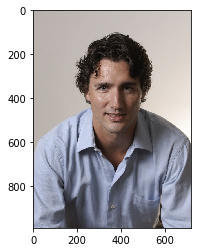

In [69]:
app("test_img/4.jpg")

Hello human!
You look like a...
Dachshund!


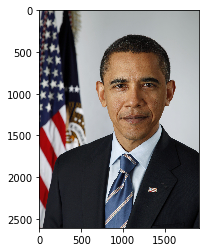

In [70]:
app("test_img/5.jpg")

Overall the algorithm performs well on new images found on the Internet. It correctly classifies the two dog breeds, and is able to detect humans. It's not tricked by the cat and orangutan images even if they are similar to other images in the dataset. 

# Web Application

I used the models developped in the previous sections to create a web application in which users can upload images to detect the dog breed. The backend relies on Python/Flask and the frontend on Boot

Full code is available here: https://github.com/tartieret/DogBreedDetector

<img src="app_screenshots/screenshot1.png">

<img src="app_screenshots/screenshot2.png">